In [266]:
#importación de modulos
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
init_printing(use_latex=True)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri
from matplotlib import cm
from scipy.spatial import ConvexHull

import subprocess as sp
import os
import shutil
import sys
import string

from scipy import interpolate

from scipy.optimize  import curve_fit
from scipy.integrate import quad

In [267]:
#Uso para generar las posiciones del ala

In [268]:
#definición de funciones

def importarXfoildata(NACA):
    """Importa los datos del perfil resultado de xfoil, deben estar dentro de una carpeta llamada Perfiles en la misma carpeta"""
    NACA=str(NACA)
    
    data=np.loadtxt('Perfiles/'+NACA+'.txt',skiprows=12) #importar todos los datos y guardarlos por variable
    alphavector=data[:,0]
    alphavectorradianes=alphavector*(np.pi/180)
    Clvector=data[:,1]
    Cdvector=data[:,2]
    Cdpvector=data[:,3]
    Cmvector=data[:,4]
    
    #interpolar cl, cd para convertirlos en función
    Clfuncion=interpolate.InterpolatedUnivariateSpline(alphavectorradianes,Clvector,k=1)
    Cdfuncion=interpolate.InterpolatedUnivariateSpline(alphavectorradianes,Cdvector,k=1)
    CdvsCl=interpolate.InterpolatedUnivariateSpline(Clvector,Cdvector,k=1)
    
    #interpola alpha sobre Cl para obtener alpha0 en radianes
    alpha0funcion=interpolate.InterpolatedUnivariateSpline(Clvector,alphavectorradianes,k=1)
    alpha0=float(alpha0funcion(0))
    
    #función para obtener la pendiente Clalpha, importante que n y -n estén en la zona linear
    n=4
    n=n*(np.pi/180)
    Clalpha=(Clfuncion(n)-Clfuncion(-n))/((n-(-n))) #da Clalpha en 1/rad
        
    return Clfuncion,Cdfuncion,CdvsCl,alpha0,Clalpha #el resultado es Cl,Cd como función y alpha0 y Clalpha

def aguilacalzada(angulocentral,angulolateral,b):
    """Calcula la geometría del ala basada en el águila calzada, las entradas son los angulos de movimiento de las articulaciones 
    de las alas y la envergadura del águila.
    """
    y=symbols('y')
    x=symbols('x')

    x=-7*y**6 #geometría de la parte delantera sin flecha
    z=x.subs(y,b/2)-0.015*(1+cos(2*(np.pi*y))) #geometría de la parte trasera sin flecha
    ccuartos=x-(x-z)/4 #línea de c cuartos
    c=(x-z) #cuerda
    articulacion=0.25
    huesocentral=-tan(rad(angulocentral))*abs(y)+ccuartos #se crean unos huesos en la línea c/4, centrales y laterales
    huesolateral=-tan(rad(angulolateral))*abs(y)+ccuartos-(tan(rad(angulocentral))-tan(rad(angulolateral)))*abs(articulacion)
    
    #convertir función simbólica con función numérica.
    x=lambdify(y,x) 
    z=lambdify(y,z)
    ccuartos=lambdify(y,ccuartos)
    cplot=lambdify(y,c)
    huesocentral=lambdify(y,huesocentral)
    huesolateral=lambdify(y,huesolateral)

    def hueso(y): 
        '''Convierte las funciones de huesocentral y huesolateral en una sola'''
        x=np.zeros(y.size)
        for i in range(y.size):
            if abs(y[i])<=articulacion :
                x[i]=huesocentral(y[i])
            else: 
                x[i]=huesolateral(y[i])
        return x

    y=np.linspace(-b/2,b/2,100)
    
    #borde de ataque y borde de salida sumando cuerda a los huesos.
    bordeataque=hueso(y)+cplot(y)/4 
    bordesalida=hueso(y)-3*cplot(y)/4
    
    bordeataque=interpolate.InterpolatedUnivariateSpline(y,bordeataque,k=1)
    bordesalida=interpolate.InterpolatedUnivariateSpline(y,bordesalida,k=1)
    
    return c,cplot,bordeataque,bordesalida

Superficie alar= 0.1087 m^2
AR= 9.1954
CLα= 6.4656 por radián
CLα= 0.1128 por grado
CL0= 0.3828
Perfil   Clα= 7.7163 por radián


/Users/Enrique/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


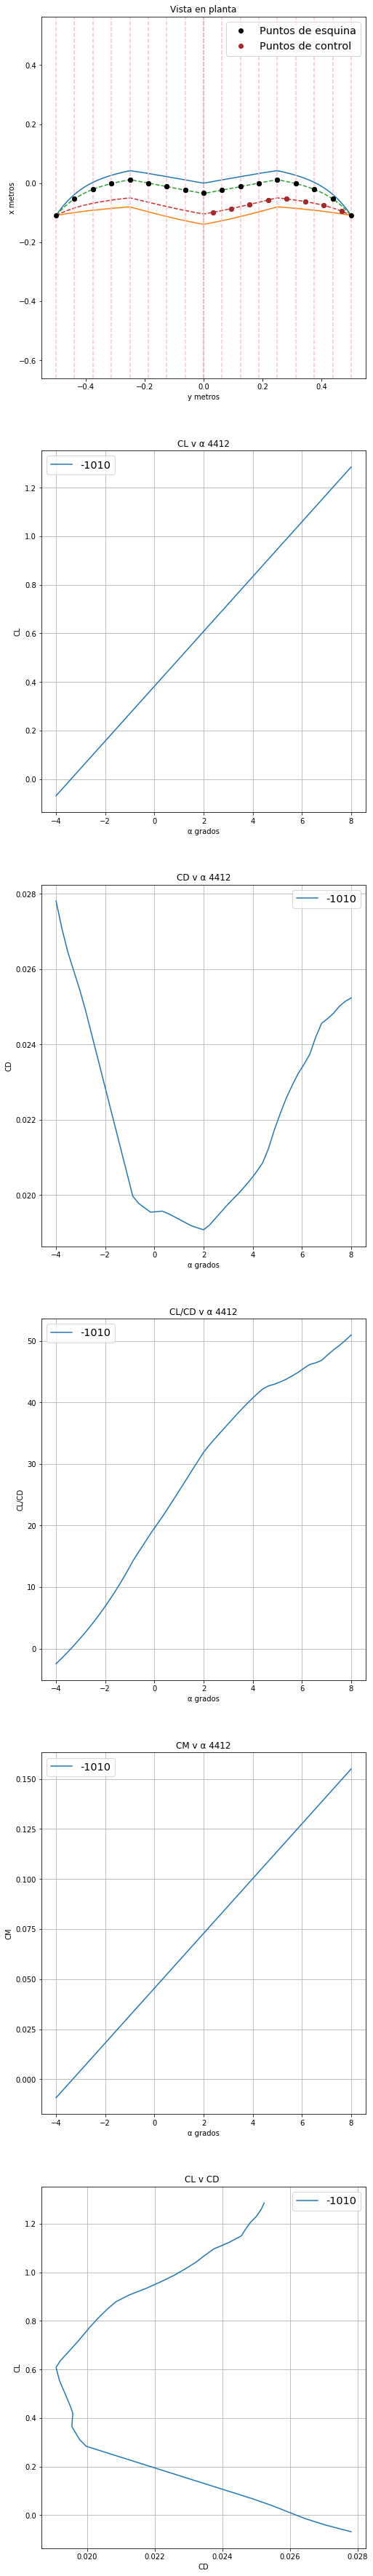

In [311]:
grafica=plt.figure()
for jk in [-10]:
    for ik in [10]:

        #-------------
        V=10
        rho=1.225
        Q=0.5*(V**2)*rho
        m=0.8
        #--------- Características del perfil
        NACA=4412

        Clfuncion,Cdfuncion,CdvsCl,alpha0,Clalpha=importarXfoildata(NACA)

        Clα=Clalpha #en 1/radianes
        Cl0=float(Clfuncion(0)) #da igual en grados o en radianes
        α0=alpha0 # cambiado a radianes
        Cdplot=Cdfuncion #como función de radianes

        #------------ Definición de la geometría

        b=1 #envergadura en metros
        angulocentral=jk
        angulolateral=ik

        y=symbols("y")

        c,cplot,bordeataque,bordesalida=aguilacalzada(angulocentral,angulolateral,b)

        twistroot=0 #torsión en la raiz
        twisttip=0 #tornsión en la punta 
        #la torsión se trata de forma lineal.

        #-------------- Parámetro de mallado
        paneles=8 #nº paneles por semiala
        #---------------

        #------- Ángulos de ataque para estudio
        alphai=-4 #alpha inicial, en grados
        alphaf=8  #alpha final, en grados
        #-------

        #---------Bloque para cálcular el Área
        caux=c
        cplot=lambdify(y,caux)
        S,errordeS=quad(cplot,-b/2,b/2)
        print('Superficie alar=',round(S,4),'m^2')
        #---------
        
        #---------Bloque para calculo de la cuerda media del ala
        def cplotcuadrado(x):
            return cplot(x)*cplot(x)
        integralccuadrado,errordec=quad(cplotcuadrado,-b/2,b/2)
        cmedia=(1/S)*integralccuadrado
        #---------
        
        #---------Bloque para calcular alargamiento
        AR=b**2/S
        print('AR=',round(AR,4))
        #---------

        #---------Bloque para el cálculo de la línea c/4 y c3/4

        def Ccuartosplot(yn):
            x=np.zeros(yn.size)
            for i in range(yn.size):
                x[i]=bordeataque(yn[i])-cplot(yn[i])/4
            return x

        def Ctrescuartosplot(yn):
            x=np.zeros(yn.size)
            for i in range(yn.size):
                x[i]=bordeataque(yn[i])-3*cplot(yn[i])/4
            return x

        #---------

        #---------Bloque para definir torsión
        twist=(twisttip-twistroot)*abs(y)/(b/2)+twistroot
        plottwist=lambdify(y,twist)
        #---------
        
        #-----------Representación gráfica de la vista en planta
        
        grafica.add_subplot(6,1,1)
        x=np.linspace(-b/2,b/2,100)
        plotbordeataque=bordeataque
        plotbordesalida=bordesalida
        plt.plot(x,plotbordeataque(x))
        plt.plot(x,plotbordesalida(x))
        plt.plot(x,Ccuartosplot(x),'--')
        plt.plot(x, Ctrescuartosplot(x),'--')
        plt.axvline(0,c='black', ls= 'dashed')
        plt.axis('equal')
        plt.title('Vista en planta')
        plt.ylabel('x metros')
        plt.xlabel('y metros')
        #-----------------

        #------------Obtención de puntos de control y matriz C de VLM

        Δy=(b/(2*paneles))#longitud en envergadura de cada panel

        def Cmatrixfunc(paneles=paneles,b=b):
            '''Calcula la función C de VLM, el vector de torsión, las cuerdas medias de los paneles
            '''
            #Parte derecha
            yd=np.linspace(0,b/2,paneles+1)
            for ii in range(paneles+1):
                plt.axvline(yd[ii],c='pink', ls= 'dashed')
                plt.axvline(-yd[ii],c='pink', ls= 'dashed')

            #coordenadas de los puntos de control de cada panel
            ym=yd[0:paneles]+(b/2)*(1/paneles)*(1/2)
            xm=-(Ctrescuartosplot(ym))

            y1n=yd[0:paneles]
            y2n=yd[1:paneles+1]

            x1n=-(Ccuartosplot(y1n))
            x2n=-(Ccuartosplot(y2n))

            plt.plot(y1n,-x1n,'o',color='black')
            plt.plot(y2n,-x2n,'o',color='black')
            plt.plot(ym,-xm,'o',color='brown')

            #torsión
            twistvector=np.zeros(paneles)
            for iii in range(paneles):
                twistvector[iii]=plottwist(ym[iii])*np.pi/180 #vector de torsión en radianes

            #Cuerda en los puntos de control
            cavvector=np.zeros(paneles)
            xccuartosvector=np.zeros(paneles)
            for jjj in range(paneles):
                cavvector[jjj]=cplot(ym[jjj])
                xccuartosvector[jjj]=-(bordeataque(ym[jjj])-cplot(ym[jjj])/4)#para el cálculo de CM

            
            #------------------calculo matriz C
            amatrix=np.zeros((paneles,paneles)) #crear matrices para rellenarlas posteriormente
            bmatrix=np.zeros((paneles,paneles))
            cmatrix=np.zeros((paneles,paneles))
            dmatrix=np.zeros((paneles,paneles))
            gmatrix=np.zeros((paneles,paneles))
            hmatrix=np.zeros((paneles,paneles))
            ematrix=np.zeros((paneles,paneles))
            fmatrix=np.zeros((paneles,paneles))
            Cmatrixderecha=np.zeros((paneles,paneles))

            for kk in range(paneles):
                for ll in range(paneles):
                    amatrix[kk,ll]=xm[kk]-x1n[ll] #definir punto por punto las distintas variables
                    bmatrix[kk,ll]=ym[kk]-y1n[ll]
                    cmatrix[kk,ll]=xm[kk]-x2n[ll]
                    dmatrix[kk,ll]=ym[kk]-y2n[ll]
                    gmatrix[kk,ll]=x2n[kk]-x1n[kk]
                    hmatrix[kk,ll]=y2n[kk]-y1n[kk]
                    ematrix[kk,ll]=sqrt(amatrix[kk,ll]**2+bmatrix[kk,ll]**2)
                    fmatrix[kk,ll]=sqrt(cmatrix[kk,ll]**2+dmatrix[kk,ll]**2)
                    a,b,c,d,e,f,g,h=amatrix[kk,ll],bmatrix[kk,ll],cmatrix[kk,ll],dmatrix[kk,ll],ematrix[kk,ll],fmatrix[kk,ll],gmatrix[kk,ll],hmatrix[kk,ll]

                    Cmatrixderecha[kk,ll]=((1/(a*d-c*b))*(((g*a+h*b)/e)-((g*c+h*d)/f))-(1/b)*(1+a/e)+(1/d)*(1+c/f))*(1/(2*Clα))
            #----------------

            #Parte izquierda
            #coordenadas de los puntos de control de cada panel
            ymi=ym 
            xmi=xm

            y1ni=-y2n
            y2ni=-y1n

            x1ni=x2n
            x2ni=x1n

            plt.plot(y1ni,-x1ni,'o',color='black',label='Puntos de esquina')
            plt.plot(y2ni,-x2ni,'o',color='black')
            plt.plot(ymi,-xmi,'o',color='brown',label='Puntos de control')
            plt.legend(fontsize='x-large')

            #------------------calculo matriz C
            amatrixi=np.zeros((paneles,paneles)) #crear matrices para rellenarlas posteriormente
            bmatrixi=np.zeros((paneles,paneles))
            cmatrixi=np.zeros((paneles,paneles))
            dmatrixi=np.zeros((paneles,paneles))
            gmatrixi=np.zeros((paneles,paneles))
            hmatrixi=np.zeros((paneles,paneles))
            ematrixi=np.zeros((paneles,paneles))
            fmatrixi=np.zeros((paneles,paneles))
            Cmatrixi=np.zeros((paneles,paneles))

            for kk in range(paneles):
                for ll in range(paneles):
                    amatrixi[kk,ll]=xmi[kk]-x1ni[ll]
                    bmatrixi[kk,ll]=ymi[kk]-y1ni[ll]
                    cmatrixi[kk,ll]=xmi[kk]-x2ni[ll]
                    dmatrixi[kk,ll]=ymi[kk]-y2ni[ll]
                    gmatrixi[kk,ll]=x2ni[kk]-x1ni[kk]
                    hmatrixi[kk,ll]=y2ni[kk]-y1ni[kk]
                    ematrixi[kk,ll]=sqrt(amatrixi[kk,ll]**2+bmatrixi[kk,ll]**2)
                    fmatrixi[kk,ll]=sqrt(cmatrixi[kk,ll]**2+dmatrixi[kk,ll]**2)
                    a,b,c,d,e,f,g,h=amatrixi[kk,ll],bmatrixi[kk,ll],cmatrixi[kk,ll],dmatrixi[kk,ll],ematrixi[kk,ll],fmatrixi[kk,ll],gmatrixi[kk,ll],hmatrixi[kk,ll]

                    Cmatrixi[kk,ll]=((1/(a*d-c*b))*(((g*a+h*b)/e)-((g*c+h*d)/f))-(1/b)*(1+a/e)+(1/d)*(1+c/f))*(1/(2*Clα))

            Cmatrix=Cmatrixderecha+Cmatrixi
            return Cmatrix,twistvector,cavvector,ym,xccuartosvector

        Cmatrix,twistvector,cavvector,ym,xccuartosvector=Cmatrixfunc()
        #--------------

        #-------------Definición de vector w y Cálculo de CL
        alphavectorgrados=np.linspace(alphai,alphaf,51)
        alphavector=alphavectorgrados*np.pi/180 #alpha en radianes


        Clpaneles=np.zeros((paneles,alphavector.size)) #creamos las matrices para luego rellenarlas
        Cdpaneles=np.zeros((paneles,alphavector.size))
        Cmpaneles=np.zeros((paneles,alphavector.size))
        
        CL=np.zeros(alphavector.size)
        CD=np.zeros(alphavector.size)
        CM=np.zeros(alphavector.size)
        L=np.zeros(alphavector.size)

        for hh in range(alphavector.size):
            wvector=np.zeros(paneles)
            for k in range(paneles):
                wvector[k]=-V*(alphavector[hh]+twistvector[k])

            Γn=np.linalg.solve(Cmatrix,wvector)
            Clpaneles[:,hh]=2*Γn/(V*cavvector)
            Clpaneles[:,hh]=Clpaneles[:,hh]-α0*Clα #se le añade el efecto de α0
            Cdpaneles[:,hh]=CdvsCl(Clpaneles[:,hh]) #Se computa Cd usando las gráficas de xfoil
            Cmpaneles[:,hh]=Clpaneles[:,hh]*xccuartosvector/cmedia
            
            CL[hh]=(2/S)*sum(Δy*cavvector*Clpaneles[:,hh]) #coeficiente de sustentación
            CD[hh]=(2/S)*sum(Δy*cavvector*Cdpaneles[:,hh]) #coeficiente de resistencia
            CM[hh]=(2/S)*sum(Δy*cavvector*Cmpaneles[:,hh])
            
            L[hh]=Q*CL[hh]*S    
        CLalpha=(CL[-1]-CL[0])/(alphavector[-1]-alphavector[0])
        CLalphaporgrado=CLalpha*np.pi/180
        CLvCD=CL/CD
        #------------

        #---------Cálculo de CL0
        CLfuncion=interpolate.InterpolatedUnivariateSpline(alphavector,CL,k=1)
        CL0=float(CLfuncion(0))
        #-----
        
        #-----------función de cálculo de α0
        
        '''def alphacerofun():
            alphacero=interpolate.InterpolatedUnivariateSpline(CL,alphavector,k=1)
            α0ala=alphacero(0)*180/np.pi
            return α0ala
        α0ala=alphacerofun()''' 
        #------

        #-----------Representación gráfica de la polar
        grafica.add_subplot(6,1,2)
        plt.plot(alphavectorgrados,CL,label=str(angulocentral)+str(angulolateral))


        grafica.add_subplot(6,1,3)
        plt.plot(alphavectorgrados,CD,label=str(angulocentral)+str(angulolateral))


        grafica.add_subplot(6,1,4)
        plt.plot(alphavectorgrados,CLvCD,label=str(angulocentral)+str(angulolateral))


        grafica.add_subplot(6,1,5)
        plt.plot(alphavectorgrados,CM,label=str(angulocentral)+str(angulolateral))
 
        
        grafica.add_subplot(6,1,6)
        plt.plot(CD,CL,label=str(angulocentral)+str(angulolateral))

        #-----------

        #-----------Bloque para guardar los datos
        filename=str(NACA)+'_'+str(angulocentral)+'_'+str(angulolateral)+'revisando'
        try:
            os.remove(filename)
        except OSError:
            pass
        
        np.save('Alas/CL'+'_'+filename,CL)
        np.save('Alas/CD'+'_'+filename,CD)
        np.save('Alas/CLvCD'+'_'+filename,CLvCD)

        Resultados=np.array([           #matriz resumen de resultados
            ['CLα por radián',round(CLalpha,4)],
            ['CLα por grado',round(CLalphaporgrado,4)],
            ['CL0',round(CL0,4)]])
            #['α0 en grados',round(α0ala,4)]])

        np.save('Alas/Resultados'+'_'+filename,Resultados)

        #-----------Print de variables
        print('CLα=',round(CLalpha,4),'por radián')
        print('CLα=',round(CLalphaporgrado,4), 'por grado')
        print('CL0=',round(CL0,4))
        #print('α0=',round(α0ala,4),'º')
        print('Perfil  ','Clα=',round(Clα,4),'por radián')
        #------

grafica.add_subplot(6,1,2)
plt.grid()
plt.title('CL v α '+str(NACA))
plt.ylabel('CL')
plt.xlabel('α grados')
plt.legend(fontsize='x-large')

grafica.add_subplot(6,1,3)
plt.grid()
plt.title('CD v α '+str(NACA))
plt.ylabel('CD')
plt.xlabel('α grados')
plt.legend(fontsize='x-large')

grafica.add_subplot(6,1,4)
plt.grid()
plt.title('CL/CD v α '+str(NACA))
plt.ylabel('CL/CD')
plt.xlabel('α grados')
plt.legend(fontsize='x-large')

grafica.add_subplot(6,1,5)
plt.grid()
plt.title('CM v α '+str(NACA))
plt.ylabel('CM')
plt.xlabel('α grados')
plt.legend(fontsize='x-large')

grafica.add_subplot(6,1,6)
plt.grid()
plt.title('CL v CD ')
plt.ylabel('CL')
plt.xlabel('CD')
plt.legend(fontsize='x-large')


grafica.set_size_inches(8, 64)

plt.savefig('Alas/'+filename+'.png')

/Users/Enrique/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in power
  # This is added back by InteractiveShellApp.init_path()


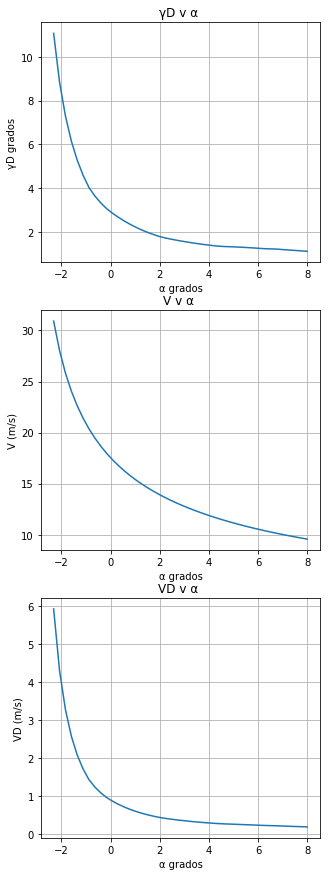

In [281]:

#Actuaciones de planeo.
grafica4=plt.figure()

W=9.81*m #Peso
γD=np.arctan(1/CLvCD) #ángulo de planeo en radianes
γDgrados=γD*(180/np.pi) #angulo de planeo en grados
#Velocidad de planeo
Vplaneo=np.sqrt(np.sqrt(((2*np.cos(γD)*W)/(rho*CL*S))**2)) 
#Velocidad de descenso
VD=(CD/CL**1.5)*np.sqrt(2*W/(rho*S))*(np.cos(γD)**1.5)

#Representación gráfica.
grafica4.add_subplot(3,1,1)
plt.plot(alphavectorgrados[7:],γDgrados[7:])
plt.grid()
plt.title('γD v α ')
plt.ylabel('γD grados')
plt.xlabel('α grados')

grafica4.add_subplot(3,1,2)
plt.plot(alphavectorgrados[7:],Vplaneo[7:])
plt.grid()
plt.title('V v α ')
plt.ylabel('V (m/s)')
plt.xlabel('α grados')
       
grafica4.add_subplot(3,1,3)
plt.plot(alphavectorgrados[7:],VD[7:])
plt.grid()
plt.title('VD v α ')
plt.ylabel('VD (m/s)')
plt.xlabel('α grados')

grafica4.set_size_inches(5, 15)

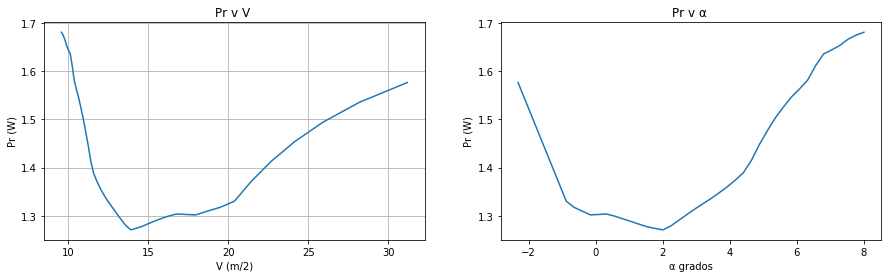

In [353]:
#Módulo para actuaciones de crucero.
rho=1.225
grafica2=plt.figure() #Se crea nueva gráfica

CLcrucero=CL[7:] #Escogemos los puntos lejos de la zona de singularidad.
Vcrucero=np.sqrt((W/(0.5*rho*S))/CLcrucero) #Velocidad crucero
Pr=0.5*rho*(V**3)*S*CD[7:] #Potencia requerida

grafica2.add_subplot(1,2,1)
plt.plot(Vcrucero,Pr)
plt.grid()
plt.title('Pr v V ')
plt.ylabel('Pr (W)')
plt.xlabel('V (m/2)')

grafica2.add_subplot(1,2,2)
plt.plot(alphavectorgrados[7:],Pr)
plt.title('Pr v α ')
plt.ylabel('Pr (W)')
plt.xlabel('α grados')

grafica2.set_size_inches(15, 4)

Text(0.5,0,'V(m/s)')

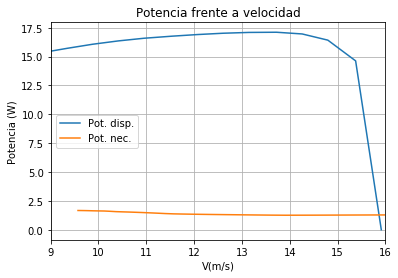

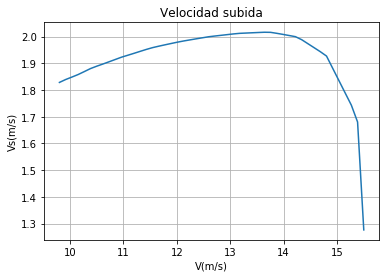

In [354]:
#Módulo para el vuelo estacionario de subida.
#para la hélice 10x10E y 3000RPM

V3000=np.array([ 0.      ,  0.536448,  1.1176  ,  1.654048,  2.190496,  2.726944,
        3.308096,  3.844544,  4.380992,  4.91744 ,  5.498592,  6.03504 ,
        6.571488,  7.107936,  7.689088,  8.225536,  8.761984,  9.343136,
        9.879584, 10.416032, 10.95248 , 11.533632, 12.07008 , 12.606528,
       13.142976, 13.724128, 14.260576, 14.797024, 15.378176, 15.914624])
PE3000=np.array([0.000e+00, 7.210e-02, 1.410e-01, 2.065e-01, 2.688e-01, 3.276e-01,
       3.831e-01, 4.353e-01, 4.842e-01, 5.299e-01, 5.725e-01, 6.120e-01,
       6.485e-01, 6.822e-01, 7.131e-01, 7.406e-01, 7.647e-01, 7.855e-01,
       8.033e-01, 8.177e-01, 8.292e-01, 8.381e-01, 8.452e-01, 8.509e-01,
       8.544e-01, 8.552e-01, 8.478e-01, 8.210e-01, 7.313e-01, 8.000e-04])

PD=PE3000*(20)

PDfuncion=interpolate.InterpolatedUnivariateSpline(V3000,PD,k=1)
Prfuncion=interpolate.InterpolatedUnivariateSpline(list(reversed(Vcrucero)),list(reversed(Pr)),k=1)
Vrango=np.linspace(9.8,15.5,50)
grafica=plt.figure()

plt.plot(V3000,PD,label='Pot. disp.')
plt.plot(Vcrucero,Pr,label='Pot. nec.')
plt.grid()
plt.title('Potencia frente a velocidad')
plt.ylabel('Potencia (W)')
plt.xlim(9,16)
#plt.ylim(1.1,1.8)
plt.xlabel('V(m/s)')
plt.legend()

grafica2=plt.figure()
plt.plot(Vrango,(PDfuncion(Vrango)-Prfuncion(Vrango))/W)

plt.grid()
plt.title('Velocidad subida')
plt.ylabel('Vs(m/s)')
plt.xlabel('V(m/s)')



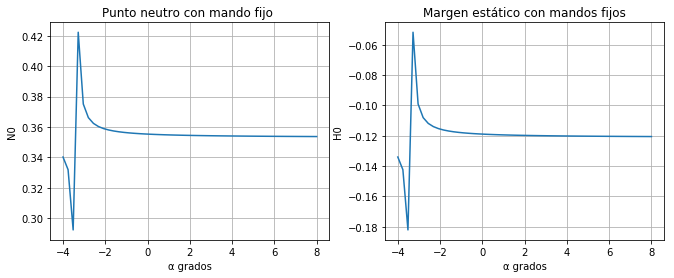

In [369]:
#estabilidad estáticalongitudinal.
xcg=0.0568
N0=(xcg/cmedia-CM/CL)
H0=N0-xcg/cmedia

grafica5=plt.figure() 
grafica5.add_subplot(1,2,1)
plt.plot(alphavectorgrados,N0)
plt.grid()
plt.title('Punto neutro con mando fijo ')
plt.ylabel('N0')
plt.xlabel('α grados')

grafica5.add_subplot(1,2,2)
plt.plot(alphavectorgrados,H0)
plt.grid()
plt.title('Margen estático con mandos fijos')
plt.ylabel('H0')
plt.xlabel('α grados')

grafica5.set_size_inches(11, 4)

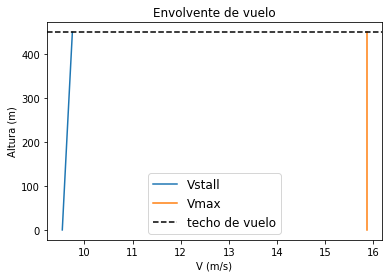

In [370]:
Clmax=1.4452
CLmax=float(0.9*Clmax*cos((atan((xccuartosvector[-1]-xccuartosvector[0])/0.5))))

hstall=np.array([0,75,150,225,300,375,450])
rhostall=np.array([1.225,1.2162,1.20746,1.19876,1.19011,1.18150,1.17295])
Vstall=np.sqrt(((2*W)/(rhostall*S*CLmax)))
Vmax=np.array([15.868,15.868,15.868,15.868,15.868,15.868,15.868])

plt.plot(Vstall,hstall,label='Vstall')
plt.plot(Vmax,hstall,label='Vmax')
plt.axhline(450,c='black', ls= 'dashed', label='techo de vuelo')
plt.title('Envolvente de vuelo')
plt.ylabel('Altura (m)')
plt.xlabel('V (m/s)')
plt.legend(fontsize='large')
